# Supervised Learning Burn Severity

In [1]:
%load_ext autoreload

In [65]:
#load in modules
%autoreload 2
from wildfireassessment.ops import * #my package
from wildfireassessment.plots import * #my package
import geopandas as gpd
import pandas as pd
import numpy as np
import numpy.ma as ma
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import matplotlib.pyplot as plt
from pathlib import Path
import math
%matplotlib inline

## Load segments
Read vector files into geodataframes. Then will convert to Numpy matrix X and y

In [3]:
#read in datapaths of labelled data
filepaths = [Path("./data/shapefiles/segments_2011023_0.shp"), Path("./data/shapefiles/segments_2011201_0.shp"),
             Path("./data/shapefiles/segments_2011203_0.shp"), Path("./data/shapefiles/segments_2010133_0.shp"),
             Path("./data/shapefiles/segments_2011200_0.shp")]

In [4]:
gdfs = []
for filepath in filepaths:
    gdfs.append(gpd.read_file(filepath))
gdfs[0].head()

,seg_index,area_m,blue_value,blue_val_1,green_valu,green_va_1,nir_value,nir_value_,red_value,red_value_,...,dSI_rb,dSI_br,dSI_gb,dSI_nr,dSI_rn,dSI_ng,dSI_bn,land_class,burn_class,geometry
0,17,3265.85,97.024300,72.765828,65.335643,50.062458,57.833333,99.000000,80.725107,56.197437,...,0.036776,-0.036776,-0.010337,-0.441008,0.441008,-0.389213,0.405810,forest,0,"POLYGON ((-121.5388488769531 39.7265625, -121...."
1,37,2659.18,94.475519,59.952203,63.518769,39.916764,45.800000,90.250000,79.149569,43.251224,...,0.073555,-0.073555,0.004681,-0.618952,0.618952,-0.548766,0.548713,forest,0,"POLYGON ((-121.5206954058479 39.7265625, -121...."
2,3,2894.16,86.018102,90.460690,65.027849,68.429520,20.533333,70.666667,75.688196,87.232648,...,-0.045714,0.045714,-0.000309,-0.468292,0.468292,-0.536115,0.491737,forest,1,"POLYGON ((-121.5505308263442 39.7265625, -121...."
3,27,5323.94,79.441831,94.398626,56.938570,64.188483,22.166667,87.633333,73.195121,77.480319,...,0.057506,-0.057506,0.025492,-0.596595,0.596595,-0.593989,0.526519,forest,0,"POLYGON ((-121.5298865823185 39.7265625, -121...."
4,47,2805.50,98.464530,62.863757,62.296575,42.170497,71.461538,92.846154,71.210939,45.611160,...,-0.001575,0.001575,-0.027965,-0.339396,0.339396,-0.306810,0.351463,forest,0,POLYGON ((-121.5225444120519 39.72651762120864...


In [5]:
#'Blue_value' - 'dSI_bn' will be X, y is 'burn_class' 
gdfs[0].keys()

Index(['seg_index', 'area_m', 'blue_value', 'blue_val_1', 'green_valu',
       'green_va_1', 'nir_value', 'nir_value_', 'red_value', 'red_value_',
       'SI_bg_post', 'SI_br_post', 'SI_bn_post', 'SI_gb_post', 'SI_gr_post',
       'SI_gn_post', 'SI_rb_post', 'SI_rg_post', 'SI_rn_post', 'SI_nb_post',
       'SI_ng_post', 'SI_nr_post', 'SI_bg_pre', 'SI_br_pre', 'SI_bn_pre',
       'SI_gb_pre', 'SI_gr_pre', 'SI_gn_pre', 'SI_rb_pre', 'SI_rg_pre',
       'SI_rn_pre', 'SI_nb_pre', 'SI_ng_pre', 'SI_nr_pre', 'dSI_nb', 'dSI_rg',
       'dSI_bg', 'dSI_gr', 'dSI_gn', 'dSI_rb', 'dSI_br', 'dSI_gb', 'dSI_nr',
       'dSI_rn', 'dSI_ng', 'dSI_bn', 'land_class', 'burn_class', 'geometry'],
      dtype='object')

In [6]:
gdf_all = pd.concat(gdfs)
gdf_all.dropna(inplace=True)
gdf_all = gdf_all.astype({'burn_class' : 'uint8'})
gdf_all

,seg_index,area_m,blue_value,blue_val_1,green_valu,green_va_1,nir_value,nir_value_,red_value,red_value_,...,dSI_rb,dSI_br,dSI_gb,dSI_nr,dSI_rn,dSI_ng,dSI_bn,land_class,burn_class,geometry
0,17,3265.85,97.024300,72.765828,65.335643,50.062458,57.833333,99.000000,80.725107,56.197437,...,0.036776,-0.036776,-0.010337,-0.441008,0.441008,-0.389213,0.405810,forest,0,"POLYGON ((-121.5388488769531 39.7265625, -121...."
1,37,2659.18,94.475519,59.952203,63.518769,39.916764,45.800000,90.250000,79.149569,43.251224,...,0.073555,-0.073555,0.004681,-0.618952,0.618952,-0.548766,0.548713,forest,0,"POLYGON ((-121.5206954058479 39.7265625, -121...."
2,3,2894.16,86.018102,90.460690,65.027849,68.429520,20.533333,70.666667,75.688196,87.232648,...,-0.045714,0.045714,-0.000309,-0.468292,0.468292,-0.536115,0.491737,forest,1,"POLYGON ((-121.5505308263442 39.7265625, -121...."
3,27,5323.94,79.441831,94.398626,56.938570,64.188483,22.166667,87.633333,73.195121,77.480319,...,0.057506,-0.057506,0.025492,-0.596595,0.596595,-0.593989,0.526519,forest,0,"POLYGON ((-121.5298865823185 39.7265625, -121...."
4,47,2805.50,98.464530,62.863757,62.296575,42.170497,71.461538,92.846154,71.210939,45.611160,...,-0.001575,0.001575,-0.027965,-0.339396,0.339396,-0.306810,0.351463,forest,0,POLYGON ((-121.5225444120519 39.72651762120864...
5,25,3930.80,79.232492,84.662461,54.582256,55.686909,23.791667,87.875000,71.843533,65.856309,...,0.076033,-0.076033,0.022241,-0.645678,0.645678,-0.617078,0.556754,forest,0,"POLYGON ((-121.5309816248277 39.7265625, -121...."
6,51,2720.56,68.351869,56.855857,48.352097,39.038628,20.333333,81.400000,55.520624,40.307315,...,0.066733,-0.066733,0.014429,-0.801517,0.801517,-0.759655,0.718976,forest,0,POLYGON ((-121.5260314941406 39.72646825453814...
7,2,4345.89,84.417933,76.088665,64.176546,53.905771,29.851852,83.370370,72.657536,61.513161,...,0.031054,-0.031054,0.034426,-0.568439,0.568439,-0.579683,0.523185,forest,1,"POLYGON ((-121.5510873233571 39.7265625, -121...."
8,4,4158.65,74.688110,79.030712,55.724711,58.391204,14.846154,68.653846,65.502199,70.291837,...,-0.007001,0.007001,0.004780,-0.618667,0.618667,-0.660035,0.598106,forest,1,"POLYGON ((-121.5499653535731 39.7265625, -121...."
9,13,3688.38,89.508993,58.461002,63.013952,38.132795,34.782609,101.782609,76.674063,36.478904,...,0.154303,-0.154303,0.036739,-0.848174,0.848174,-0.743591,0.710655,forest,1,"POLYGON ((-121.5420936135685 39.7265625, -121...."


In [7]:
df = gdf_all.drop(columns=['seg_index', 'area_m', 'geometry'])
df.head()

,blue_value,blue_val_1,green_valu,green_va_1,nir_value,nir_value_,red_value,red_value_,SI_bg_post,SI_br_post,...,dSI_gn,dSI_rb,dSI_br,dSI_gb,dSI_nr,dSI_rn,dSI_ng,dSI_bn,land_class,burn_class
0,97.024300,72.765828,65.335643,50.062458,57.833333,99.000000,80.725107,56.197437,0.195175,0.091698,...,0.389213,0.036776,-0.036776,-0.010337,-0.441008,0.441008,-0.389213,0.405810,forest,0
1,94.475519,59.952203,63.518769,39.916764,45.800000,90.250000,79.149569,43.251224,0.195936,0.088270,...,0.548766,0.073555,-0.073555,0.004681,-0.618952,0.618952,-0.548766,0.548713,forest,0
2,86.018102,90.460690,65.027849,68.429520,20.533333,70.666667,75.688196,87.232648,0.138966,0.063881,...,0.536115,-0.045714,0.045714,-0.000309,-0.468292,0.468292,-0.536115,0.491737,forest,1
3,79.441831,94.398626,56.938570,64.188483,22.166667,87.633333,73.195121,77.480319,0.165004,0.040925,...,0.593989,0.057506,-0.057506,0.025492,-0.596595,0.596595,-0.593989,0.526519,forest,0
4,98.464530,62.863757,62.296575,42.170497,71.461538,92.846154,71.210939,45.611160,0.224980,0.160622,...,0.306810,-0.001575,0.001575,-0.027965,-0.339396,0.339396,-0.306810,0.351463,forest,0


In [8]:
df_rm = df.drop(columns=['SI_bg_post', 'SI_br_post', 'SI_bn_post', 'SI_bg_pre', 'SI_br_pre', 'SI_bn_pre',
                     'SI_gr_post', 'SI_gn_post', 'SI_gr_pre', 'SI_gn_pre', 'SI_rn_post', 'SI_rn_pre', 
                     'dSI_bg', 'dSI_gr', 'dSI_gn', 'dSI_br', 'dSI_rn', 'dSI_bn'])
df_rm.head()

,blue_value,blue_val_1,green_valu,green_va_1,nir_value,nir_value_,red_value,red_value_,SI_gb_post,SI_rb_post,...,SI_ng_pre,SI_nr_pre,dSI_nb,dSI_rg,dSI_rb,dSI_gb,dSI_nr,dSI_ng,land_class,burn_class
0,97.024300,72.765828,65.335643,50.062458,57.833333,99.000000,80.725107,56.197437,-0.195175,-0.091698,...,0.328302,0.275794,-0.405810,0.047628,0.036776,-0.010337,-0.441008,-0.389213,forest,0
1,94.475519,59.952203,63.518769,39.916764,45.800000,90.250000,79.149569,43.251224,-0.195936,-0.088270,...,0.386683,0.352048,-0.548713,0.069467,0.073555,0.004681,-0.618952,-0.548766,forest,0
2,86.018102,90.460690,65.027849,68.429520,20.533333,70.666667,75.688196,87.232648,-0.138966,-0.063881,...,0.016083,-0.104915,-0.491737,-0.045037,-0.045714,-0.000309,-0.468292,-0.536115,forest,1
3,79.441831,94.398626,56.938570,64.188483,22.166667,87.633333,73.195121,77.480319,-0.165004,-0.040925,...,0.154423,0.061491,-0.526519,0.031099,0.057506,0.025492,-0.596595,-0.593989,forest,0
4,98.464530,62.863757,62.296575,42.170497,71.461538,92.846154,71.210939,45.611160,-0.224980,-0.160622,...,0.375329,0.341152,-0.351463,0.027575,-0.001575,-0.027965,-0.339396,-0.306810,forest,0


In [9]:
df_rm[(df_rm.land_class == 'water') & (df_rm.burn_class == 1)]

,blue_value,blue_val_1,green_valu,green_va_1,nir_value,nir_value_,red_value,red_value_,SI_gb_post,SI_rb_post,...,SI_ng_pre,SI_nr_pre,dSI_nb,dSI_rg,dSI_rb,dSI_gb,dSI_nr,dSI_ng,land_class,burn_class
2044,79.566475,117.877576,57.324989,96.987528,25.695652,101.26087,58.310217,90.607873,-0.162475,-0.154169,...,0.021555,0.055522,-0.43595,0.042528,-0.02337,-0.065251,-0.443764,-0.402537,water,1


In [10]:
df_rm.at[2044, 'burn_class'] = 0

In [11]:
counts = []
categories = list(df_rm['land_class'].values)
cats = list(np.unique(categories))
for cat in cats:
    counts.append((cat, categories.count(cat)))
df_stats = pd.DataFrame(counts, columns=['land_class', '#_of_segments'])
df_stats

,land_class,#_of_segments
0,forest,9673
1,grassland,3292
2,shrubland,49
3,urban,977
4,water,95


In [12]:
counts = []
categories = list(df_rm['land_class'].values)
burn_cats = list(df_rm['burn_class'].values)
both_cats = list(zip(categories, burn_cats))
cats = list(set(both_cats))
for cat in cats:
    counts.append((cat, both_cats.count(cat)))
counts.append((('water', 1), 0))
print(counts)
print(set(categories))

[(('forest', 0), 3705), (('shrubland', 0), 12), (('water', 0), 95), (('shrubland', 1), 37), (('urban', 0), 301), (('grassland', 1), 2353), (('urban', 1), 676), (('grassland', 0), 939), (('forest', 1), 5968), (('water', 1), 0)]
{'shrubland', 'grassland', 'forest', 'urban', 'water'}


In [13]:
counts.sort(key=lambda tup: tup[0][0])
counts

[(('forest', 0), 3705),
 (('forest', 1), 5968),
 (('grassland', 1), 2353),
 (('grassland', 0), 939),
 (('shrubland', 0), 12),
 (('shrubland', 1), 37),
 (('urban', 0), 301),
 (('urban', 1), 676),
 (('water', 0), 95),
 (('water', 1), 0)]

In [14]:
index = [tup[0] for (tup, count) in counts if tup[1]==0]
print(index)

['forest', 'grassland', 'shrubland', 'urban', 'water']


In [15]:
df_stats = pd.DataFrame({
    'burnt': [count for (tup, count) in counts if tup[1]==1],
    'non-burnt': [count for (tup, count) in counts if tup[1]==0]
}, index=index)
df_stats

,burnt,non-burnt
forest,5968,3705
grassland,2353,939
shrubland,37,12
urban,676,301
water,0,95


Text(0.5, 0, 'land class')

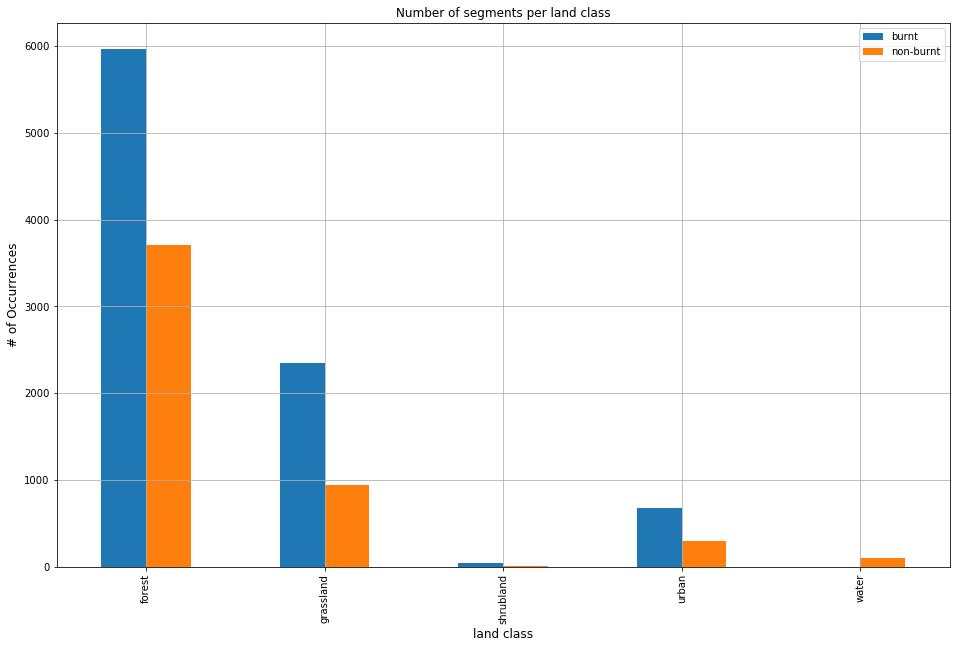

In [16]:
df_stats.plot.bar(grid=True, figsize=(16, 10))
plt.title("Number of segments per land class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('land class', fontsize=12)

#### Transform the prediction target y

In [18]:
both_cats = ["{}_{}".format(a,b) for a, b in zip(categories, burn_cats)]
both_cats

['forest_0',
 'forest_0',
 'forest_1',
 'forest_0',
 'forest_0',
 'forest_0',
 'forest_0',
 'forest_1',
 'forest_1',
 'forest_1',
 'forest_0',
 'forest_1',
 'forest_0',
 'forest_1',
 'forest_0',
 'forest_1',
 'forest_1',
 'forest_0',
 'forest_1',
 'forest_1',
 'forest_1',
 'forest_0',
 'forest_0',
 'forest_0',
 'forest_0',
 'forest_1',
 'forest_0',
 'forest_0',
 'forest_0',
 'forest_0',
 'forest_0',
 'forest_0',
 'forest_1',
 'forest_1',
 'forest_0',
 'forest_1',
 'forest_1',
 'grassland_0',
 'forest_1',
 'forest_1',
 'forest_0',
 'forest_0',
 'forest_1',
 'forest_1',
 'forest_0',
 'forest_1',
 'forest_0',
 'forest_0',
 'forest_0',
 'forest_0',
 'grassland_0',
 'forest_0',
 'urban_0',
 'forest_0',
 'forest_0',
 'forest_1',
 'forest_0',
 'forest_1',
 'forest_1',
 'forest_1',
 'forest_1',
 'forest_0',
 'forest_1',
 'forest_0',
 'forest_0',
 'forest_1',
 'forest_0',
 'forest_1',
 'forest_0',
 'forest_1',
 'forest_1',
 'forest_0',
 'forest_1',
 'forest_1',
 'forest_0',
 'forest_0',
 'grass

In [19]:
df_rm.head()

,blue_value,blue_val_1,green_valu,green_va_1,nir_value,nir_value_,red_value,red_value_,SI_gb_post,SI_rb_post,...,SI_ng_pre,SI_nr_pre,dSI_nb,dSI_rg,dSI_rb,dSI_gb,dSI_nr,dSI_ng,land_class,burn_class
0,97.024300,72.765828,65.335643,50.062458,57.833333,99.000000,80.725107,56.197437,-0.195175,-0.091698,...,0.328302,0.275794,-0.405810,0.047628,0.036776,-0.010337,-0.441008,-0.389213,forest,0
1,94.475519,59.952203,63.518769,39.916764,45.800000,90.250000,79.149569,43.251224,-0.195936,-0.088270,...,0.386683,0.352048,-0.548713,0.069467,0.073555,0.004681,-0.618952,-0.548766,forest,0
2,86.018102,90.460690,65.027849,68.429520,20.533333,70.666667,75.688196,87.232648,-0.138966,-0.063881,...,0.016083,-0.104915,-0.491737,-0.045037,-0.045714,-0.000309,-0.468292,-0.536115,forest,1
3,79.441831,94.398626,56.938570,64.188483,22.166667,87.633333,73.195121,77.480319,-0.165004,-0.040925,...,0.154423,0.061491,-0.526519,0.031099,0.057506,0.025492,-0.596595,-0.593989,forest,0
4,98.464530,62.863757,62.296575,42.170497,71.461538,92.846154,71.210939,45.611160,-0.224980,-0.160622,...,0.375329,0.341152,-0.351463,0.027575,-0.001575,-0.027965,-0.339396,-0.306810,forest,0


In [20]:
#build X and y
X = df_rm.drop(columns=['land_class','burn_class']).to_numpy()

In [22]:
le = LabelEncoder()
y = le.fit_transform(both_cats)
print(le.classes_)

['forest_0' 'forest_1' 'grassland_0' 'grassland_1' 'shrubland_0'
 'shrubland_1' 'urban_0' 'urban_1' 'water_0']


### X y shuffled train-test split 67/33

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

In [25]:
print("train shape: ", X_train.shape)
print("test shape: ", X_test.shape)

train shape:  (9437, 26)
test shape:  (4649, 26)


# Multi-label Classification

## Random Forest Classifier

In [26]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
rf.score(X_test, y_test)

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7825338782533878

In [27]:
confusion_matrix(y_test, y_predict)

array([[ 997,  177,   19,   10,    0,    0,    5,   14,    1],
       [ 182, 1693,   10,   60,    0,    1,    4,   19,    1],
       [  38,   24,  177,   63,    0,    0,    7,    1,    0],
       [   3,  117,   51,  601,    0,    0,    5,    0,    0],
       [   2,    1,    0,    0,    0,    0,    1,    0,    0],
       [   4,    4,    0,    0,    0,    1,    3,    0,    0],
       [  35,   16,   10,    7,    0,    2,   22,    7,    0],
       [  28,   64,    4,    4,    0,    2,    1,  120,    0],
       [   3,    1,    0,    0,    0,    0,    0,    0,   27]],
      dtype=int64)

In [50]:
le.transform(le.classes_)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

Confusion matrix, without normalization
[[ 997  177   19   10    0    0    5   14    1]
 [ 182 1693   10   60    0    1    4   19    1]
 [  38   24  177   63    0    0    7    1    0]
 [   3  117   51  601    0    0    5    0    0]
 [   2    1    0    0    0    0    1    0    0]
 [   4    4    0    0    0    1    3    0    0]
 [  35   16   10    7    0    2   22    7    0]
 [  28   64    4    4    0    2    1  120    0]
 [   3    1    0    0    0    0    0    0   27]]
Normalized confusion matrix
[[8.15208504e-01 1.44726083e-01 1.55355683e-02 8.17661488e-03
  0.00000000e+00 0.00000000e+00 4.08830744e-03 1.14472608e-02
  8.17661488e-04]
 [9.23857868e-02 8.59390863e-01 5.07614213e-03 3.04568528e-02
  0.00000000e+00 5.07614213e-04 2.03045685e-03 9.64467005e-03
  5.07614213e-04]
 [1.22580645e-01 7.74193548e-02 5.70967742e-01 2.03225806e-01
  0.00000000e+00 0.00000000e+00 2.25806452e-02 3.22580645e-03
  0.00000000e+00]
 [3.86100386e-03 1.50579151e-01 6.56370656e-02 7.73487773e-01
  0.0000000

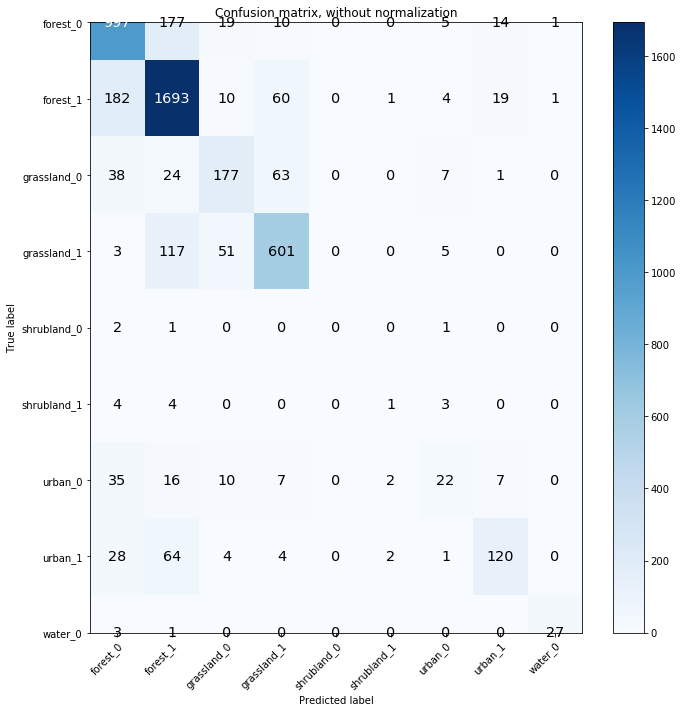

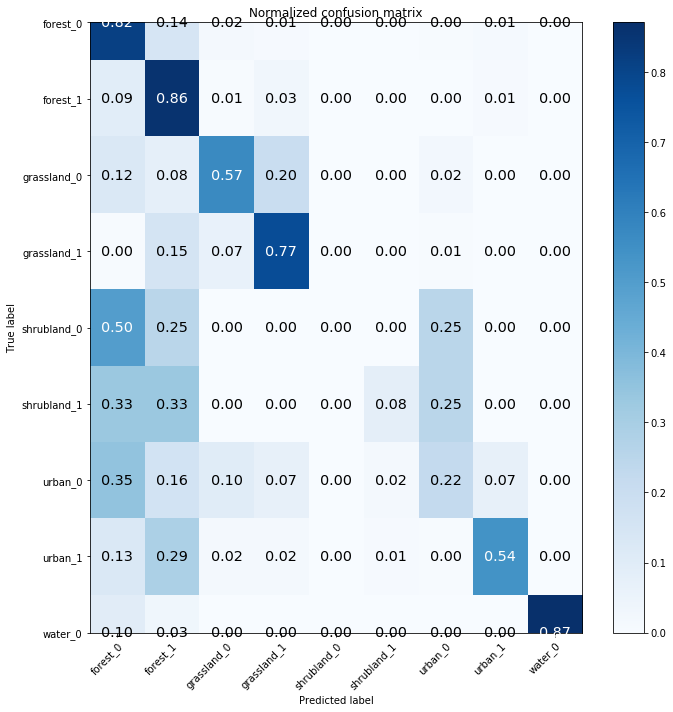

In [66]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=list(le.classes_),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=list(le.classes_), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [46]:
from sklearn import metrics
print("Accuracy:")
print(metrics.accuracy_score(y_test, y_predict))

print("\nPrecision:")
print("Macro:", metrics.precision_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.precision_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

print("\nRecall:")
print("Macro:",metrics.recall_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.recall_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

print("\nF1-score:")
print("Macro:",metrics.f1_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.f1_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

Accuracy:
0.7825338782533878

Precision:
Macro: 0.5933599655070371
Micro: 0.7825338782533878
Weighted: 0.7756414964860366

Recall:
Macro: 0.5259660857184651
Micro: 0.7825338782533878
Weighted: 0.7756414964860366

F1-score:
Macro: 0.5510970154034931
Micro: 0.7825338782533878
Weighted: 0.7756414964860366


C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
print(metrics.classification_report(y_test, y_predict, target_names=list(le.classes_)))

              precision    recall  f1-score   support

    forest_0       0.77      0.82      0.79      1223
    forest_1       0.81      0.86      0.83      1970
 grassland_0       0.65      0.57      0.61       310
 grassland_1       0.81      0.77      0.79       777
 shrubland_0       0.00      0.00      0.00         4
 shrubland_1       0.17      0.08      0.11        12
     urban_0       0.46      0.22      0.30        99
     urban_1       0.75      0.54      0.62       223
     water_0       0.93      0.87      0.90        31

    accuracy                           0.78      4649
   macro avg       0.59      0.53      0.55      4649
weighted avg       0.78      0.78      0.78      4649



C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Cross_val_score

In [42]:
scores_rf = cross_val_score(rf, X_train, y_train, cv=10)
scores_rf_p = cross_val_score(rf, X_train, y_train, scoring='precision_weighted', cv=10)
scores_rf_r = cross_val_score(rf, X_train, y_train, scoring='recall_weighted', cv=10)
scores_rf_f = cross_val_score(rf, X_train, y_train, scoring='f1_weighted', cv=10)
scores_rf

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 

array([0.76476793, 0.78797468, 0.77589852, 0.77354497, 0.74470339,
       0.78154825, 0.78237792, 0.7537155 , 0.78723404, 0.76251331])

In [43]:
def strScoreConf(mean, std, conf=1.96):
    return "%0.4f (+/- %0.4f)" % (mean, std * conf)

def strScoreCI(mean, std, conf=1.96, n=10):
    SE = std/math.sqrt(n)
    return "%0.4f (+/- %0.4f)" % (mean, SE * conf)#"95%% CI: [%0.4f, %0.4f]" % (mean - conf*SE, mean + conf*SE)

models_df_rf = pd.DataFrame({  
  'Model': ['RandForest'],
  'Accuracy' : [strScoreConf(scores_rf.mean(), scores_rf.std())],
  'Precision': [strScoreConf(scores_rf_p.mean(), scores_rf_p.std())],
  'Recall' : [strScoreConf(scores_rf_r.mean(), scores_rf_r.std())],
  'F1' : [strScoreConf(scores_rf_f.mean(), scores_rf_f.std())]
})

models_df_rf_CI = pd.DataFrame({  
  'Model': ['RandForest'],
  'Accuracy' : [strScoreCI(scores_rf.mean(), scores_rf.std())],
  'Precision': [strScoreCI(scores_rf_p.mean(), scores_rf_p.std())],
  'Recall' : [strScoreCI(scores_rf_r.mean(), scores_rf_r.std())],
  'F1' : [strScoreCI(scores_rf_f.mean(), scores_rf_f.std())]
})
models_df_rf

,Model,Accuracy,Precision,Recall,F1
0,RandForest,0.7714 (+/- 0.0272),0.7645 (+/- 0.0374),0.7735 (+/- 0.0318),0.7647 (+/- 0.0311)


In [44]:
models_df_rf_CI

,Model,Accuracy,Precision,Recall,F1
0,RandForest,0.7714 (+/- 0.0086),0.7645 (+/- 0.0118),0.7735 (+/- 0.0101),0.7647 (+/- 0.0098)


In [45]:
print("95%% CI: [%0.4f, %0.4f]" % (scores_rf.mean() - 1.96*scores_rf.std()/math.sqrt(10), scores_rf.mean() + 1.96*scores_rf.std()/math.sqrt(10)))

95% CI: [0.7628, 0.7800]


## Logistic Regression

In [67]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
lr.score(X_test, y_test)

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7330608733060874

Confusion matrix, without normalization
[[ 904  274   36    7    0    0    1    1    0]
 [ 160 1719   14   69    0    0    3    5    0]
 [  27   32  139  107    0    0    5    0    0]
 [   4  129   39  603    0    0    2    0    0]
 [   3    1    0    0    0    0    0    0    0]
 [   2    7    0    0    0    0    3    0    0]
 [  32   25   15    9    0    0   16    2    0]
 [  36  179    1    7    0    0    0    0    0]
 [   3    1    0    0    0    0    0    0   27]]
Normalized confusion matrix
[[7.39165985e-01 2.24039248e-01 2.94358136e-02 5.72363042e-03
  0.00000000e+00 0.00000000e+00 8.17661488e-04 8.17661488e-04
  0.00000000e+00]
 [8.12182741e-02 8.72588832e-01 7.10659898e-03 3.50253807e-02
  0.00000000e+00 0.00000000e+00 1.52284264e-03 2.53807107e-03
  0.00000000e+00]
 [8.70967742e-02 1.03225806e-01 4.48387097e-01 3.45161290e-01
  0.00000000e+00 0.00000000e+00 1.61290323e-02 0.00000000e+00
  0.00000000e+00]
 [5.14800515e-03 1.66023166e-01 5.01930502e-02 7.76061776e-01
  0.0000000

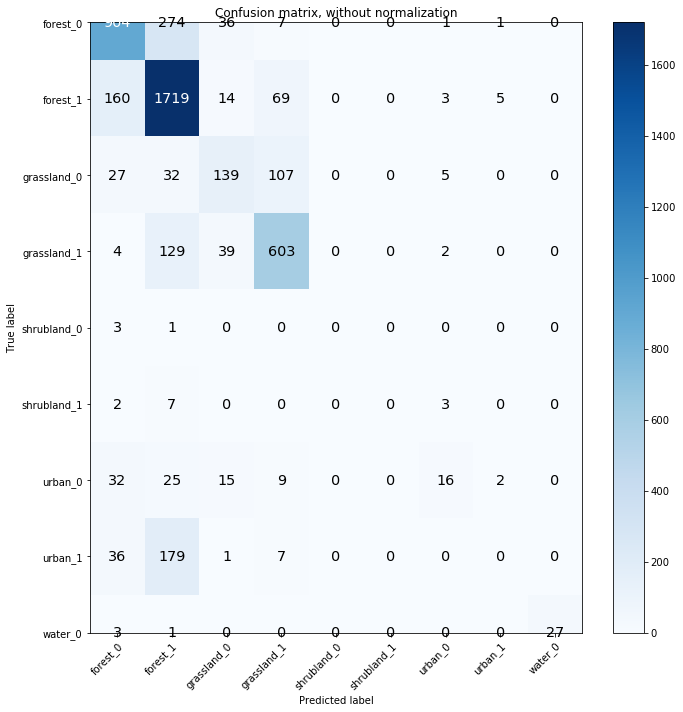

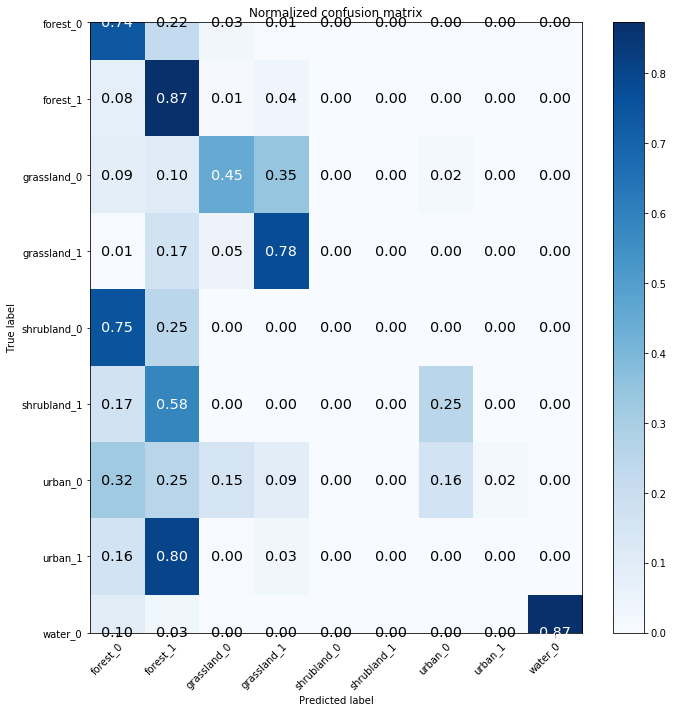

In [68]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=list(le.classes_),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=list(le.classes_), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [69]:
from sklearn import metrics
print("Accuracy:")
print(metrics.accuracy_score(y_test, y_predict))

print("\nPrecision:")
print("Macro:", metrics.precision_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.precision_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

print("\nRecall:")
print("Macro:",metrics.recall_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.recall_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

print("\nF1-score:")
print("Macro:",metrics.f1_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.f1_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

Accuracy:
0.7330608733060874

Precision:
Macro: 0.48367792027374307
Micro: 0.7330608733060874
Weighted: 0.6924993504666607

Recall:
Macro: 0.4298652882396687
Micro: 0.7330608733060874
Weighted: 0.6924993504666607

F1-score:
Macro: 0.44362348195203133
Micro: 0.7330608733060874
Weighted: 0.6924993504666607


C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [70]:
print(metrics.classification_report(y_test, y_predict, target_names=list(le.classes_)))

              precision    recall  f1-score   support

    forest_0       0.77      0.74      0.76      1223
    forest_1       0.73      0.87      0.79      1970
 grassland_0       0.57      0.45      0.50       310
 grassland_1       0.75      0.78      0.76       777
 shrubland_0       0.00      0.00      0.00         4
 shrubland_1       0.00      0.00      0.00        12
     urban_0       0.53      0.16      0.25        99
     urban_1       0.00      0.00      0.00       223
     water_0       1.00      0.87      0.93        31

    accuracy                           0.73      4649
   macro avg       0.48      0.43      0.44      4649
weighted avg       0.69      0.73      0.71      4649



C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Cross Validation

In [71]:
scores_lr = cross_val_score(lr, X_train, y_train, cv=10)
scores_lr_p = cross_val_score(lr, X_train, y_train, scoring='precision_weighted', cv=10)
scores_lr_r = cross_val_score(lr, X_train, y_train, scoring='recall_weighted', cv=10)
scores_lr_f = cross_val_score(lr, X_train, y_train, scoring='f1_weighted', cv=10)
scores_lr

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ail

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ailin\Anaconda

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ail

array([0.7035865 , 0.7257384 , 0.70824524, 0.70793651, 0.70868644,
       0.72534464, 0.70063694, 0.70382166, 0.73723404, 0.72949947])

In [72]:
models_df_lr = pd.DataFrame({
  'Model': ['LogReg'],
  'Accuracy' : [strScoreConf(scores_lr.mean(), scores_lr.std())],
  'Precision': [strScoreConf(scores_lr_p.mean(), scores_lr_p.std())],
  'Recall' : [strScoreConf(scores_lr_r.mean(), scores_lr_r.std())],
  'F1' : [strScoreConf(scores_lr_f.mean(), scores_lr_f.std())]
})
models_df_lr

,Model,Accuracy,Precision,Recall,F1
0,LogReg,0.7151 (+/- 0.0242),0.6755 (+/- 0.0292),0.7151 (+/- 0.0242),0.6881 (+/- 0.0236)


## Naive Bayes

### Gaussian NB

In [73]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_predict = gnb.predict(X_test)
gnb.score(X_test, y_test)

0.6468057646805765

Confusion matrix, without normalization
[[ 880  138   61   11   18    9   23   77    6]
 [ 242 1167   38  157   20   25   32  289    0]
 [  15   11  190   78    2    0   11    3    0]
 [   2   49  171  530    3    0   10   12    0]
 [   2    0    1    0    0    1    0    0    0]
 [   0    2    0    0    1    8    1    0    0]
 [  13    3   21    8    1   10   18   25    0]
 [   8    9    6    5    4    6    0  185    0]
 [   0    1    0    0    0    0    1    0   29]]
Normalized confusion matrix
[[0.71954211 0.11283729 0.04987735 0.00899428 0.01471791 0.00735895
  0.01880621 0.06295993 0.00490597]
 [0.12284264 0.59238579 0.01928934 0.07969543 0.01015228 0.01269036
  0.01624365 0.14670051 0.        ]
 [0.0483871  0.03548387 0.61290323 0.2516129  0.00645161 0.
  0.03548387 0.00967742 0.        ]
 [0.002574   0.06306306 0.22007722 0.68211068 0.003861   0.
  0.01287001 0.01544402 0.        ]
 [0.5        0.         0.25       0.         0.         0.25
  0.         0.         0.        ]
 

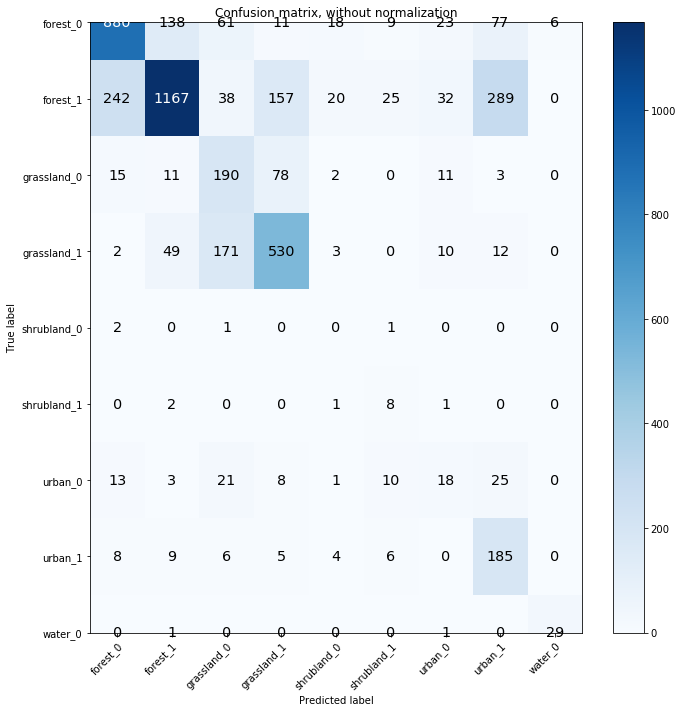

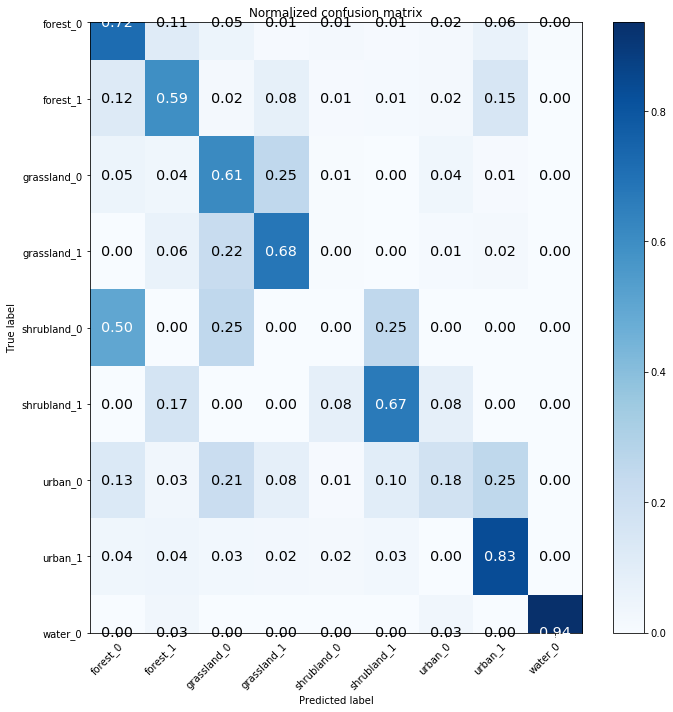

In [74]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=list(le.classes_),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=list(le.classes_), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [75]:
print("Accuracy:")
print(metrics.accuracy_score(y_test, y_predict))

print("\nPrecision:")
print("Macro:", metrics.precision_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.precision_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

print("\nRecall:")
print("Macro:",metrics.recall_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.recall_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

print("\nF1-score:")
print("Macro:",metrics.f1_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.f1_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

Accuracy:
0.6468057646805765

Precision:
Macro: 0.458749022140536
Micro: 0.6468057646805765
Weighted: 0.7206813569207977

Recall:
Macro: 0.5800563262549387
Micro: 0.6468057646805765
Weighted: 0.7206813569207977

F1-score:
Macro: 0.4812263330800254
Micro: 0.6468057646805765
Weighted: 0.7206813569207977


In [76]:
print(metrics.classification_report(y_test, y_predict, target_names=list(le.classes_)))

              precision    recall  f1-score   support

    forest_0       0.76      0.72      0.74      1223
    forest_1       0.85      0.59      0.70      1970
 grassland_0       0.39      0.61      0.48       310
 grassland_1       0.67      0.68      0.68       777
 shrubland_0       0.00      0.00      0.00         4
 shrubland_1       0.14      0.67      0.23        12
     urban_0       0.19      0.18      0.18        99
     urban_1       0.31      0.83      0.45       223
     water_0       0.83      0.94      0.88        31

    accuracy                           0.65      4649
   macro avg       0.46      0.58      0.48      4649
weighted avg       0.72      0.65      0.67      4649



#### Cross-validation

In [77]:
scores_gnb = cross_val_score(gnb, X_train, y_train, cv=10)
scores_gnb_p = cross_val_score(gnb, X_train, y_train, scoring='precision_weighted', cv=10)
scores_gnb_r = cross_val_score(gnb, X_train, y_train, scoring='recall_weighted', cv=10)
scores_gnb_f = cross_val_score(gnb, X_train, y_train, scoring='f1_weighted', cv=10)
scores_gnb

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: 

array([0.64135021, 0.64240506, 0.61945032, 0.64761905, 0.63559322,
       0.65959703, 0.63694268, 0.64649682, 0.65      , 0.6485623 ])

In [78]:
models_df_gnb = pd.DataFrame({  
  'Model': ['GaussNB'],
  'Accuracy' : [strScoreConf(scores_gnb.mean(), scores_gnb.std())],
  'Precision': [strScoreConf(scores_gnb_p.mean(), scores_gnb_p.std())],
  'Recall' : [strScoreConf(scores_gnb_r.mean(), scores_gnb_r.std())],
  'F1' : [strScoreConf(scores_gnb_f.mean(), scores_gnb_f.std())]
})
models_df_gnb

,Model,Accuracy,Precision,Recall,F1
0,GaussNB,0.6428 (+/- 0.0200),0.7069 (+/- 0.0151),0.6428 (+/- 0.0200),0.6592 (+/- 0.0168)


### Bernoulli NB

In [79]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
y_predict = bnb.predict(X_test)
bnb.score(X_test, y_test)

0.6317487631748763

Confusion matrix, without normalization
[[ 626  462    0   89    0   19    0    0   27]
 [ 114 1627    0  220    0    4    0    0    5]
 [  22   34    0  254    0    0    0    0    0]
 [   2  120    2  653    0    0    0    0    0]
 [   2    1    0    1    0    0    0    0    0]
 [   2    4    1    3    0    2    0    0    0]
 [   8   41    0   46    0    4    0    0    0]
 [  17  182    0   24    0    0    0    0    0]
 [   0    2    0    0    0    0    0    0   29]]
Normalized confusion matrix
[[0.51185609 0.37775961 0.         0.07277187 0.         0.01553557
  0.         0.         0.02207686]
 [0.05786802 0.82588832 0.         0.11167513 0.         0.00203046
  0.         0.         0.00253807]
 [0.07096774 0.10967742 0.         0.81935484 0.         0.
  0.         0.         0.        ]
 [0.002574   0.15444015 0.002574   0.84041184 0.         0.
  0.         0.         0.        ]
 [0.5        0.25       0.         0.25       0.         0.
  0.         0.         0.        ]
 [0

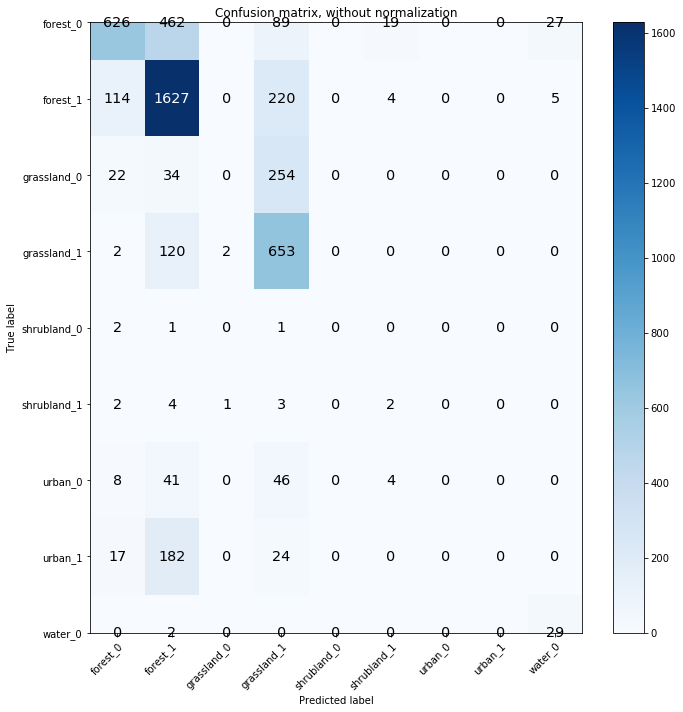

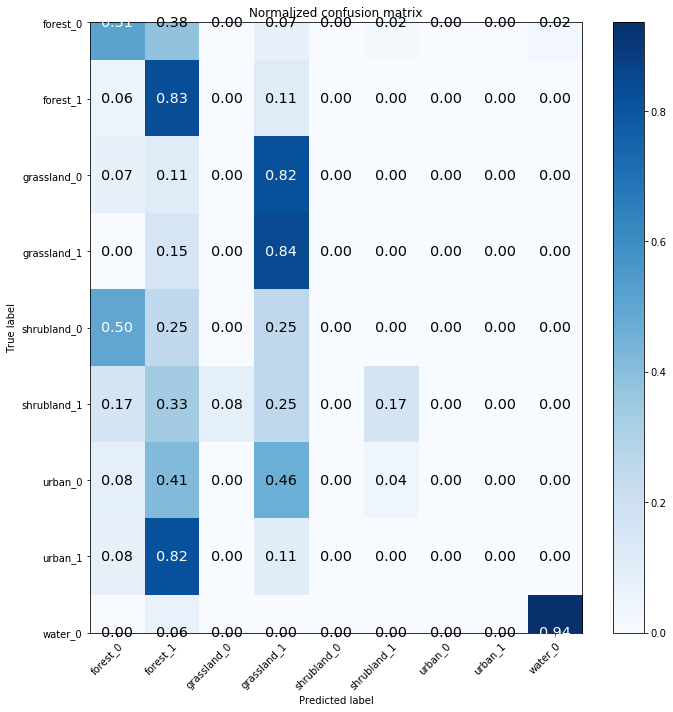

In [80]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=list(le.classes_),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=list(le.classes_), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [81]:
print("Accuracy:")
print(metrics.accuracy_score(y_test, y_predict))

print("\nPrecision:")
print("Macro:", metrics.precision_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.precision_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

print("\nRecall:")
print("Macro:",metrics.recall_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.recall_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

print("\nF1-score:")
print("Macro:",metrics.f1_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.f1_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

Accuracy:
0.6317487631748763

Precision:
Macro: 0.27754328841948084
Micro: 0.6317487631748763
Weighted: 0.5744036643620366

Recall:
Macro: 0.3644785327219369
Micro: 0.6317487631748763
Weighted: 0.5744036643620366

F1-score:
Macro: 0.301472122843165
Micro: 0.6317487631748763
Weighted: 0.5744036643620366


C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [82]:
print(metrics.classification_report(y_test, y_predict, target_names=list(le.classes_)))

              precision    recall  f1-score   support

    forest_0       0.79      0.51      0.62      1223
    forest_1       0.66      0.83      0.73      1970
 grassland_0       0.00      0.00      0.00       310
 grassland_1       0.51      0.84      0.63       777
 shrubland_0       0.00      0.00      0.00         4
 shrubland_1       0.07      0.17      0.10        12
     urban_0       0.00      0.00      0.00        99
     urban_1       0.00      0.00      0.00       223
     water_0       0.48      0.94      0.63        31

    accuracy                           0.63      4649
   macro avg       0.28      0.36      0.30      4649
weighted avg       0.57      0.63      0.58      4649



C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Cross-validation

In [83]:
scores_bnb = cross_val_score(bnb, X_train, y_train, cv=10)
scores_bnb_p = cross_val_score(bnb, X_train, y_train, scoring='precision_weighted', cv=10)
scores_bnb_r = cross_val_score(bnb, X_train, y_train, scoring='recall_weighted', cv=10)
scores_bnb_f = cross_val_score(bnb, X_train, y_train, scoring='f1_weighted', cv=10)
scores_bnb

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 

array([0.62130802, 0.63818565, 0.59196617, 0.61058201, 0.58898305,
       0.62460233, 0.61358811, 0.60509554, 0.61914894, 0.60170394])

In [84]:
models_df_bnb = pd.DataFrame({  
  'Model': ['BernNB'],
  'Accuracy' : [strScoreConf(scores_bnb.mean(), scores_bnb.std())],
  'Precision': [strScoreConf(scores_bnb_p.mean(), scores_bnb_p.std())],
  'Recall' : [strScoreConf(scores_bnb_r.mean(), scores_bnb_r.std())],
  'F1' : [strScoreConf(scores_bnb_f.mean(), scores_bnb_f.std())]
})
models_df_bnb

,Model,Accuracy,Precision,Recall,F1
0,BernNB,0.6115 (+/- 0.0282),0.5703 (+/- 0.0437),0.6115 (+/- 0.0282),0.5649 (+/- 0.0254)


## Stochastic Gradient Descent (SGD)

In [85]:
sgd = linear_model.SGDClassifier()
sgd.fit(X_train, y_train)
y_predict = sgd.predict(X_test)
sgd.score(X_test, y_test) #around 72-78%

0.6354054635405464

Confusion matrix, without normalization
[[ 604  574    7    1    0    0    0   36    1]
 [  81 1844    0   20    0    0    0   25    0]
 [  18  137   66   86    0    0    0    3    0]
 [   0  363    2  412    0    0    0    0    0]
 [   1    1    0    0    0    0    0    2    0]
 [   0    6    0    0    0    0    0    6    0]
 [  12   62    1    3    0    2    0   19    0]
 [  10  207    0    4    0    0    0    2    0]
 [   0    3    0    0    0    0    0    2   26]]
Normalized confusion matrix
[[4.93867539e-01 4.69337694e-01 5.72363042e-03 8.17661488e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 2.94358136e-02
  8.17661488e-04]
 [4.11167513e-02 9.36040609e-01 0.00000000e+00 1.01522843e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.26903553e-02
  0.00000000e+00]
 [5.80645161e-02 4.41935484e-01 2.12903226e-01 2.77419355e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 9.67741935e-03
  0.00000000e+00]
 [0.00000000e+00 4.67181467e-01 2.57400257e-03 5.30244530e-01
  0.0000000

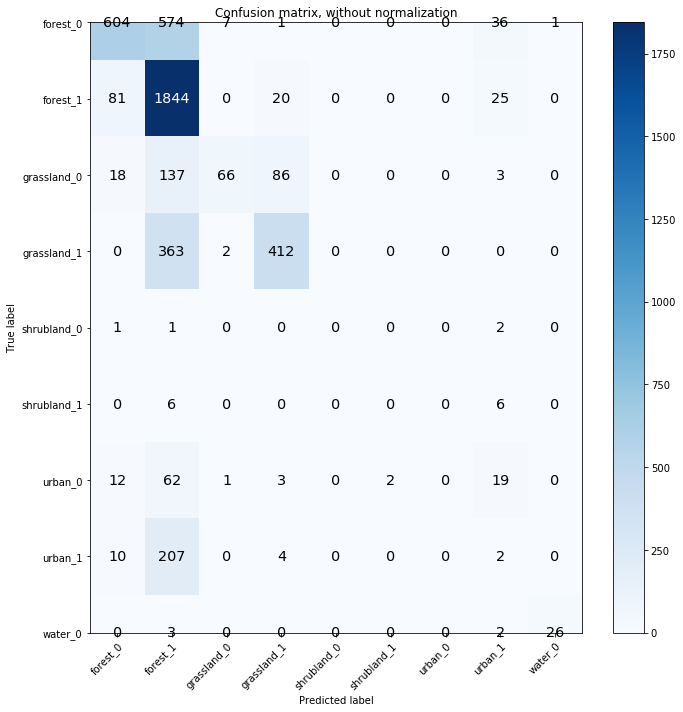

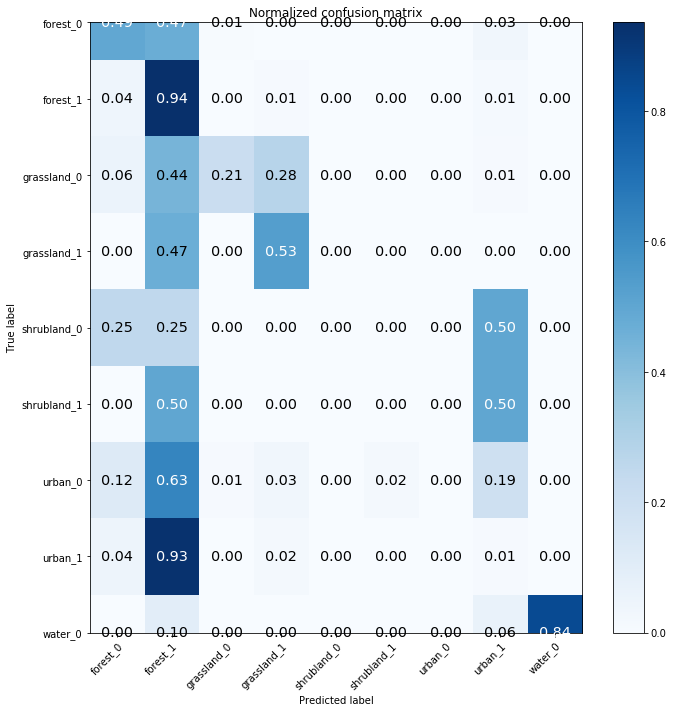

In [86]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=list(le.classes_),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=list(le.classes_), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [87]:
print("Accuracy:")
print(metrics.accuracy_score(y_test, y_predict))

print("\nPrecision:")
print("Macro:", metrics.precision_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.precision_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

print("\nRecall:")
print("Macro:",metrics.recall_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.recall_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

print("\nF1-score:")
print("Macro:",metrics.f1_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.f1_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

Accuracy:
0.6354054635405464

Precision:
Macro: 0.4493836970372974
Micro: 0.6354054635405464
Weighted: 0.6595219895741681

Recall:
Macro: 0.33563713236797604
Micro: 0.6354054635405464
Weighted: 0.6595219895741681

F1-score:
Macro: 0.3574501647638356
Micro: 0.6354054635405464
Weighted: 0.6595219895741681


C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [88]:
print(metrics.classification_report(y_test, y_predict, target_names=list(le.classes_)))

              precision    recall  f1-score   support

    forest_0       0.83      0.49      0.62      1223
    forest_1       0.58      0.94      0.71      1970
 grassland_0       0.87      0.21      0.34       310
 grassland_1       0.78      0.53      0.63       777
 shrubland_0       0.00      0.00      0.00         4
 shrubland_1       0.00      0.00      0.00        12
     urban_0       0.00      0.00      0.00        99
     urban_1       0.02      0.01      0.01       223
     water_0       0.96      0.84      0.90        31

    accuracy                           0.64      4649
   macro avg       0.45      0.34      0.36      4649
weighted avg       0.66      0.64      0.60      4649



C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Cross-validation

In [89]:
scores_sgd = cross_val_score(sgd, X_train, y_train, cv=10)
scores_sgd_p = cross_val_score(sgd, X_train, y_train, scoring='precision_weighted', cv=10)
scores_sgd_r = cross_val_score(sgd, X_train, y_train, scoring='recall_weighted', cv=10)
scores_sgd_f = cross_val_score(sgd, X_train, y_train, scoring='f1_weighted', cv=10)
scores_sgd

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 

array([0.65611814, 0.54219409, 0.46300211, 0.61587302, 0.29131356,
       0.63944857, 0.60403397, 0.52760085, 0.64787234, 0.40042599])

In [90]:
models_df_sgd = pd.DataFrame({  
  'Model': ['SGD'],
  'Accuracy' : [strScoreConf(scores_sgd.mean(), scores_sgd.std())],
  'Precision': [strScoreConf(scores_sgd_p.mean(), scores_sgd_p.std())],
  'Recall' : [strScoreConf(scores_sgd_r.mean(), scores_sgd_r.std())],
  'F1' : [strScoreConf(scores_sgd_f.mean(), scores_sgd_f.std())]
})
models_df_sgd

,Model,Accuracy,Precision,Recall,F1
0,SGD,0.5388 (+/- 0.2254),0.6558 (+/- 0.1500),0.6065 (+/- 0.0954),0.5015 (+/- 0.2264)


## K-Nearest Neighbors

In [91]:
knn = KNeighborsClassifier() # n = 5
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
knn.score(X_test, y_test)

0.7339212733921273

Confusion matrix, without normalization
[[ 918  228   27   16    0    0    5   27    2]
 [ 249 1577   21   77    0    1    4   41    0]
 [  31   25  166   80    0    0    7    1    0]
 [   9  109   67  591    0    0    1    0    0]
 [   3    1    0    0    0    0    0    0    0]
 [   1    8    0    1    0    1    0    1    0]
 [  31   18   19    9    0    1   14    7    0]
 [  27   61    0    9    0    0    5  121    0]
 [   5    2    0    0    0    0    0    0   24]]
Normalized confusion matrix
[[7.50613246e-01 1.86426819e-01 2.20768602e-02 1.30825838e-02
  0.00000000e+00 0.00000000e+00 4.08830744e-03 2.20768602e-02
  1.63532298e-03]
 [1.26395939e-01 8.00507614e-01 1.06598985e-02 3.90862944e-02
  0.00000000e+00 5.07614213e-04 2.03045685e-03 2.08121827e-02
  0.00000000e+00]
 [1.00000000e-01 8.06451613e-02 5.35483871e-01 2.58064516e-01
  0.00000000e+00 0.00000000e+00 2.25806452e-02 3.22580645e-03
  0.00000000e+00]
 [1.15830116e-02 1.40283140e-01 8.62290862e-02 7.60617761e-01
  0.0000000

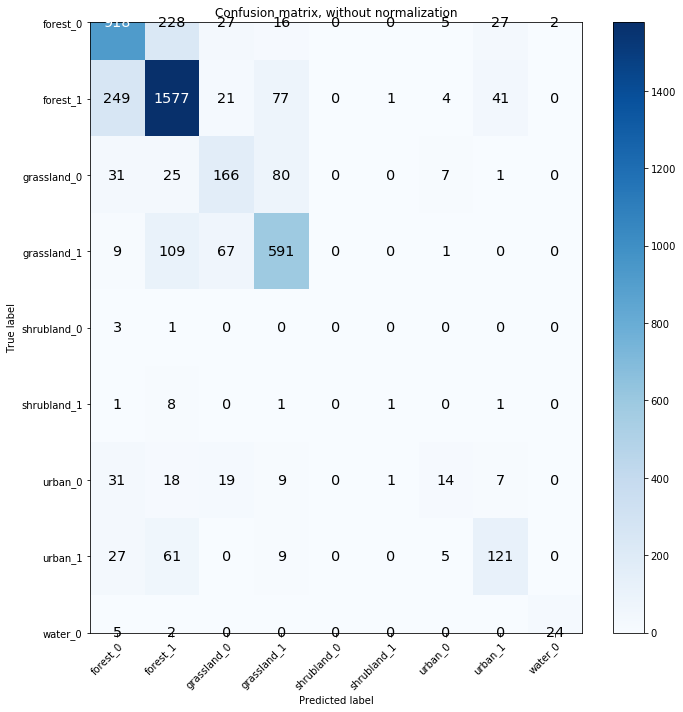

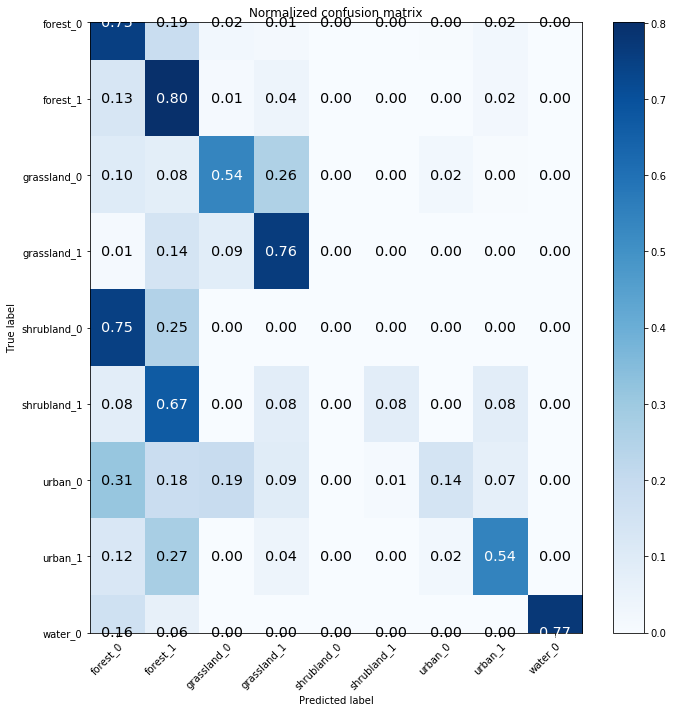

In [92]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=list(le.classes_),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=list(le.classes_), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [94]:
print("Accuracy:")
print(metrics.accuracy_score(y_test, y_predict))

print("\nPrecision:")
print("Macro:", metrics.precision_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.precision_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

print("\nRecall:")
print("Macro:",metrics.recall_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.recall_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

print("\nF1-score:")
print("Macro:",metrics.f1_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.f1_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

Accuracy:
0.7339212733921273

Precision:
Macro: 0.5624809081725016
Micro: 0.7339212733921273
Weighted: 0.7265632088389947

Recall:
Macro: 0.487640490212263
Micro: 0.7339212733921273
Weighted: 0.7265632088389947

F1-score:
Macro: 0.5092891080560714
Micro: 0.7339212733921273
Weighted: 0.7265632088389947


C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [95]:
print(metrics.classification_report(y_test, y_predict, target_names=list(le.classes_)))

              precision    recall  f1-score   support

    forest_0       0.72      0.75      0.74      1223
    forest_1       0.78      0.80      0.79      1970
 grassland_0       0.55      0.54      0.54       310
 grassland_1       0.75      0.76      0.76       777
 shrubland_0       0.00      0.00      0.00         4
 shrubland_1       0.33      0.08      0.13        12
     urban_0       0.39      0.14      0.21        99
     urban_1       0.61      0.54      0.57       223
     water_0       0.92      0.77      0.84        31

    accuracy                           0.73      4649
   macro avg       0.56      0.49      0.51      4649
weighted avg       0.73      0.73      0.73      4649



C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Cross-validation

In [96]:
scores_knn = cross_val_score(knn, X_train, y_train, cv=10)
scores_knn_p = cross_val_score(knn, X_train, y_train, scoring='precision_weighted', cv=10)
scores_knn_r = cross_val_score(knn, X_train, y_train, scoring='recall_weighted', cv=10)
scores_knn_f = cross_val_score(knn, X_train, y_train, scoring='f1_weighted', cv=10)
scores_knn

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 

array([0.7278481 , 0.73628692, 0.71881607, 0.71111111, 0.70021186,
       0.74549311, 0.74734607, 0.74203822, 0.7393617 , 0.72736954])

In [97]:
models_df_knn = pd.DataFrame({  
  'Model': ['KNN'],
  'Accuracy' : [strScoreConf(scores_knn.mean(), scores_knn.std())],
  'Precision': [strScoreConf(scores_knn_p.mean(), scores_knn_p.std())],
  'Recall' : [strScoreConf(scores_knn_r.mean(), scores_knn_r.std())],
  'F1' : [strScoreConf(scores_knn_f.mean(), scores_knn_f.std())]
})
models_df_knn

,Model,Accuracy,Precision,Recall,F1
0,KNN,0.7296 (+/- 0.0290),0.7230 (+/- 0.0298),0.7296 (+/- 0.0290),0.7241 (+/- 0.0291)


## Decision Tree

In [98]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_predict = dtc.predict(X_test)
dtc.score(X_test, y_test)

0.7091847709184771

Confusion matrix, without normalization
[[ 884  235   27   16    1    3   18   33    6]
 [ 232 1520   25  112    3    5   17   56    0]
 [  32   36  162   67    0    1   10    2    0]
 [  14  107   75  567    0    1   10    3    0]
 [   2    1    0    0    0    0    1    0    0]
 [   2    2    0    1    1    3    2    1    0]
 [  28   18   16    4    0    2   24    7    0]
 [  33   59    4    6    0    2    8  111    0]
 [   2    2    1    0    0    0    0    0   26]]
Normalized confusion matrix
[[7.22812756e-01 1.92150450e-01 2.20768602e-02 1.30825838e-02
  8.17661488e-04 2.45298446e-03 1.47179068e-02 2.69828291e-02
  4.90596893e-03]
 [1.17766497e-01 7.71573604e-01 1.26903553e-02 5.68527919e-02
  1.52284264e-03 2.53807107e-03 8.62944162e-03 2.84263959e-02
  0.00000000e+00]
 [1.03225806e-01 1.16129032e-01 5.22580645e-01 2.16129032e-01
  0.00000000e+00 3.22580645e-03 3.22580645e-02 6.45161290e-03
  0.00000000e+00]
 [1.80180180e-02 1.37709138e-01 9.65250965e-02 7.29729730e-01
  0.0000000

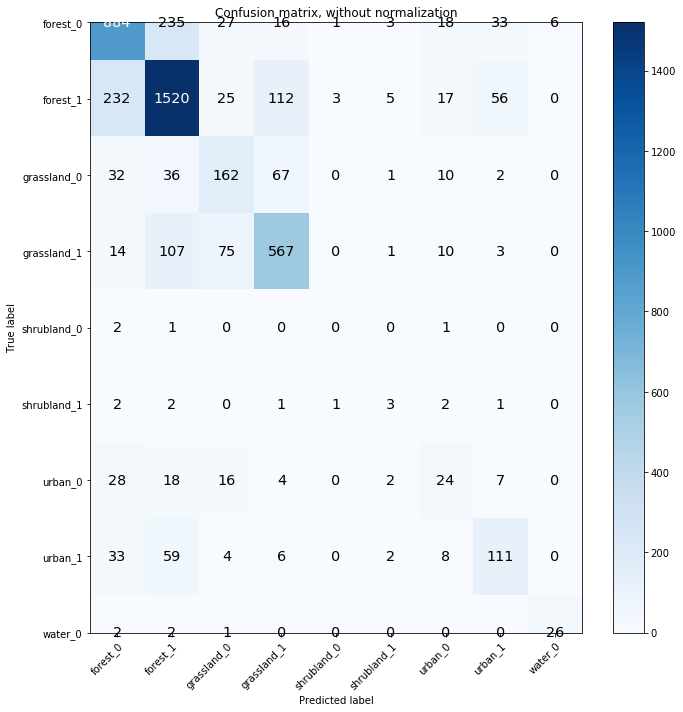

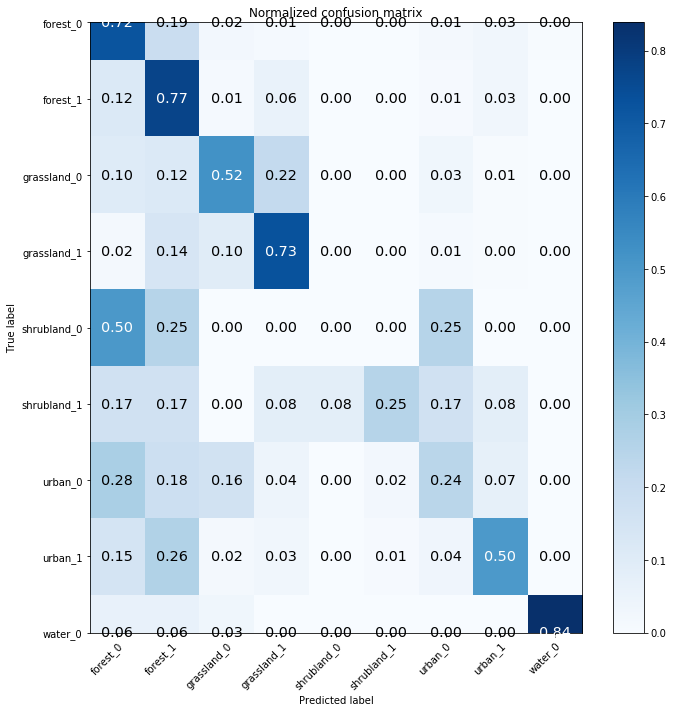

In [99]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=list(le.classes_),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=list(le.classes_), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [100]:
print("Accuracy:")
print(metrics.accuracy_score(y_test, y_predict))

print("\nPrecision:")
print("Macro:", metrics.precision_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.precision_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

print("\nRecall:")
print("Macro:",metrics.recall_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.recall_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

print("\nF1-score:")
print("Macro:",metrics.f1_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.f1_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

Accuracy:
0.7091847709184771

Precision:
Macro: 0.502201246720674
Micro: 0.7091847709184771
Weighted: 0.7085089194341454

Recall:
Macro: 0.5083987224275976
Micro: 0.7091847709184771
Weighted: 0.7085089194341454

F1-score:
Macro: 0.5044770878049416
Micro: 0.7091847709184771
Weighted: 0.7085089194341454


In [101]:
print(metrics.classification_report(y_test, y_predict, target_names=list(le.classes_)))

              precision    recall  f1-score   support

    forest_0       0.72      0.72      0.72      1223
    forest_1       0.77      0.77      0.77      1970
 grassland_0       0.52      0.52      0.52       310
 grassland_1       0.73      0.73      0.73       777
 shrubland_0       0.00      0.00      0.00         4
 shrubland_1       0.18      0.25      0.21        12
     urban_0       0.27      0.24      0.25        99
     urban_1       0.52      0.50      0.51       223
     water_0       0.81      0.84      0.83        31

    accuracy                           0.71      4649
   macro avg       0.50      0.51      0.50      4649
weighted avg       0.71      0.71      0.71      4649



#### Cross-validation

In [102]:
scores_dtc = cross_val_score(dtc, X_train, y_train, cv=10)
scores_dtc_p = cross_val_score(dtc, X_train, y_train, scoring='precision_weighted', cv=10)
scores_dtc_r = cross_val_score(dtc, X_train, y_train, scoring='recall_weighted', cv=10)
scores_dtc_f = cross_val_score(dtc, X_train, y_train, scoring='f1_weighted', cv=10)
scores_dtc

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 

array([0.68037975, 0.7278481 , 0.69133192, 0.69206349, 0.6684322 ,
       0.69777306, 0.70700637, 0.67728238, 0.70851064, 0.70181044])

In [103]:
models_df_dtc = pd.DataFrame({  
  'Model': ['DecnTree'],
  'Accuracy' : [strScoreConf(scores_dtc.mean(), scores_dtc.std())],
  'Precision': [strScoreConf(scores_dtc_p.mean(), scores_dtc_p.std())],
  'Recall' : [strScoreConf(scores_dtc_r.mean(), scores_dtc_r.std())],
  'F1' : [strScoreConf(scores_dtc_f.mean(), scores_dtc_f.std())]
})
models_df_dtc

,Model,Accuracy,Precision,Recall,F1
0,DecnTree,0.6952 (+/- 0.0323),0.6945 (+/- 0.0268),0.6955 (+/- 0.0321),0.6962 (+/- 0.0265)


## SVM

In [120]:
#Support Vector Classifier
svc_lin = svm.SVC(kernel='linear', max_iter=10000)
svc_rbf = svm.SVC(kernel='rbf', max_iter=10000)
svc_poly = svm.SVC(kernel='poly', max_iter=10000)

svc_lin.fit(X_train, y_train)
svc_rbf.fit(X_train, y_train)
svc_poly.fit(X_train, y_train)

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='poly', max_iter=10000, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [121]:
y_pred_l = svc_lin.predict(X_test)
y_pred_r = svc_rbf.predict(X_test)
y_pred_p = svc_poly.predict(X_test)

#### Results SVC linear kernel

In [122]:
print(confusion_matrix(y_test, y_pred_l))
print(metrics.classification_report(y_test, y_pred_l, target_names=list(le.classes_)))

[[ 724  281   26   43   20   13   66   27   23]
 [1037  519  109  100    0    6   62  131    6]
 [   8   19   49  212    0    0    9   13    0]
 [  22   51  152  445    0    0    5  102    0]
 [   2    0    1    0    0    0    1    0    0]
 [   7    0    0    1    3    0    0    1    0]
 [  32    8    4   30    2    5    7   11    0]
 [ 152   23    1    9    0    0   11   27    0]
 [   0    1    1    0    0    0    0    0   29]]
              precision    recall  f1-score   support

    forest_0       0.36      0.59      0.45      1223
    forest_1       0.58      0.26      0.36      1970
 grassland_0       0.14      0.16      0.15       310
 grassland_1       0.53      0.57      0.55       777
 shrubland_0       0.00      0.00      0.00         4
 shrubland_1       0.00      0.00      0.00        12
     urban_0       0.04      0.07      0.05        99
     urban_1       0.09      0.12      0.10       223
     water_0       0.50      0.94      0.65        31

    accuracy             

#### Results SVC RBF kernel

In [123]:
print(confusion_matrix(y_test, y_pred_r))
print(metrics.classification_report(y_test, y_pred_r, target_names=list(le.classes_)))

[[ 388  826    0    1    0    0    1    7    0]
 [  76 1868    0   15    0    0    0   11    0]
 [   5  254   13   38    0    0    0    0    0]
 [   3  444    6  324    0    0    0    0    0]
 [   1    3    0    0    0    0    0    0    0]
 [   0   12    0    0    0    0    0    0    0]
 [   9   85    0    1    0    0    0    4    0]
 [  13  146    0    1    0    0    0   63    0]
 [   0   24    0    0    0    0    0    0    7]]
              precision    recall  f1-score   support

    forest_0       0.78      0.32      0.45      1223
    forest_1       0.51      0.95      0.66      1970
 grassland_0       0.68      0.04      0.08       310
 grassland_1       0.85      0.42      0.56       777
 shrubland_0       0.00      0.00      0.00         4
 shrubland_1       0.00      0.00      0.00        12
     urban_0       0.00      0.00      0.00        99
     urban_1       0.74      0.28      0.41       223
     water_0       1.00      0.23      0.37        31

    accuracy             

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Results SVC polynomial kernel

In [124]:
print(confusion_matrix(y_test, y_pred_p))
print(metrics.classification_report(y_test, y_pred_p, target_names=list(le.classes_)))

[[ 160  388    9    6    6    4    9  635    6]
 [ 162  619    6   75    3    9   47 1049    0]
 [ 200   25   51   21    0    0    3   10    0]
 [ 533   58   14  134    0    0    0   38    0]
 [   0    2    0    0    0    1    0    1    0]
 [   3    1    0    0    0    6    0    2    0]
 [  39    9    4    1    1    6    0   39    0]
 [  10    9    0    0    0    4   19  181    0]
 [   1   10    0    0    0    0    0    1   19]]
              precision    recall  f1-score   support

    forest_0       0.14      0.13      0.14      1223
    forest_1       0.55      0.31      0.40      1970
 grassland_0       0.61      0.16      0.26       310
 grassland_1       0.57      0.17      0.26       777
 shrubland_0       0.00      0.00      0.00         4
 shrubland_1       0.20      0.50      0.29        12
     urban_0       0.00      0.00      0.00        99
     urban_1       0.09      0.81      0.17       223
     water_0       0.76      0.61      0.68        31

    accuracy             

#### Cross-validation

In [125]:
#trying RBF since it is the default parameter
scores_svc = cross_val_score(svm.SVC(max_iter=10000), X_train, y_train, cv=10)
scores_svc_p = cross_val_score(svm.SVC(max_iter=10000), X_train, y_train, scoring='precision_weighted', cv=10)
scores_svc_r = cross_val_score(svm.SVC(max_iter=10000), X_train, y_train, scoring='recall_weighted', cv=10)
scores_svc_f = cross_val_score(svm.SVC(max_iter=10000), X_train, y_train, scoring='f1_weighted', cv=10)
scores_svc

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to acc

array([0.56329114, 0.57489451, 0.5782241 , 0.55661376, 0.55720339,
       0.5630965 , 0.56687898, 0.56050955, 0.55638298, 0.56443024])

In [126]:
models_df_svc = pd.DataFrame({  
  'Model': ['SVM'],
  'Accuracy' : [strScoreConf(scores_svc.mean(), scores_svc.std())],
  'Precision': [strScoreConf(scores_svc_p.mean(), scores_svc_p.std())],
  'Recall' : [strScoreConf(scores_svc_r.mean(), scores_svc_r.std())],
  'F1' : [strScoreConf(scores_svc_f.mean(), scores_svc_f.std())]
})
models_df_svc

,Model,Accuracy,Precision,Recall,F1
0,SVM,0.5642 (+/- 0.0139),0.6514 (+/- 0.0340),0.5642 (+/- 0.0139),0.5073 (+/- 0.0187)


## ANN - Multi-layer Perceptron Classifier (MLP)

In [104]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
y_predict = mlp.predict(X_test)
knn.score(X_test, y_test)

0.7339212733921273

Confusion matrix, without normalization
[[ 880  274   11   10    0    4   12   30    2]
 [ 121 1734    4   64    0    6   12   29    0]
 [  29   42  101  118    0    0   20    0    0]
 [   1  104   12  652    0    0    8    0    0]
 [   1    1    0    0    0    2    0    0    0]
 [   0    5    0    0    0    3    1    3    0]
 [  25   24    5    7    0    5   24    9    0]
 [  18   91    0    6    0    0    2  106    0]
 [   2    2    0    0    0    0    0    0   27]]
Normalized confusion matrix
[[0.71954211 0.22403925 0.00899428 0.00817661 0.         0.00327065
  0.00981194 0.02452984 0.00163532]
 [0.06142132 0.88020305 0.00203046 0.03248731 0.         0.00304569
  0.00609137 0.01472081 0.        ]
 [0.09354839 0.13548387 0.32580645 0.38064516 0.         0.
  0.06451613 0.         0.        ]
 [0.001287   0.13384813 0.01544402 0.83912484 0.         0.
  0.01029601 0.         0.        ]
 [0.25       0.25       0.         0.         0.         0.5
  0.         0.         0.        ]
 [

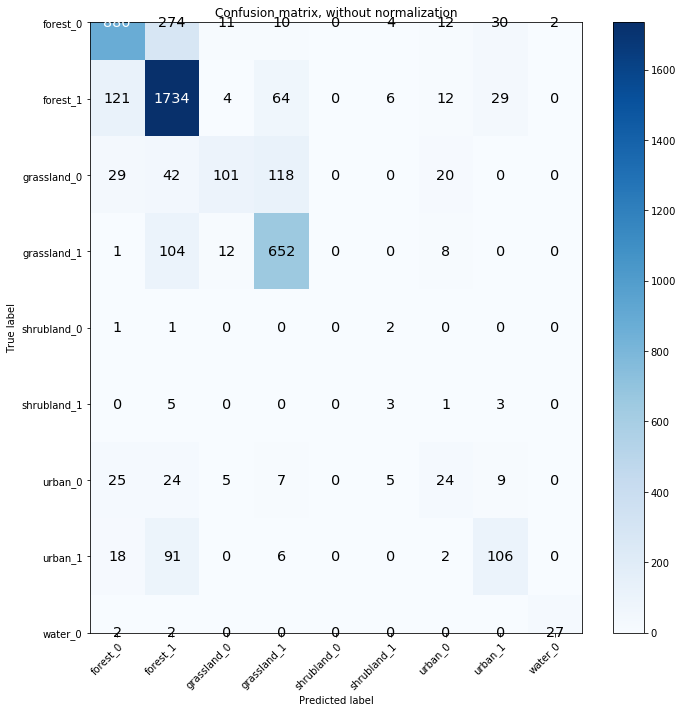

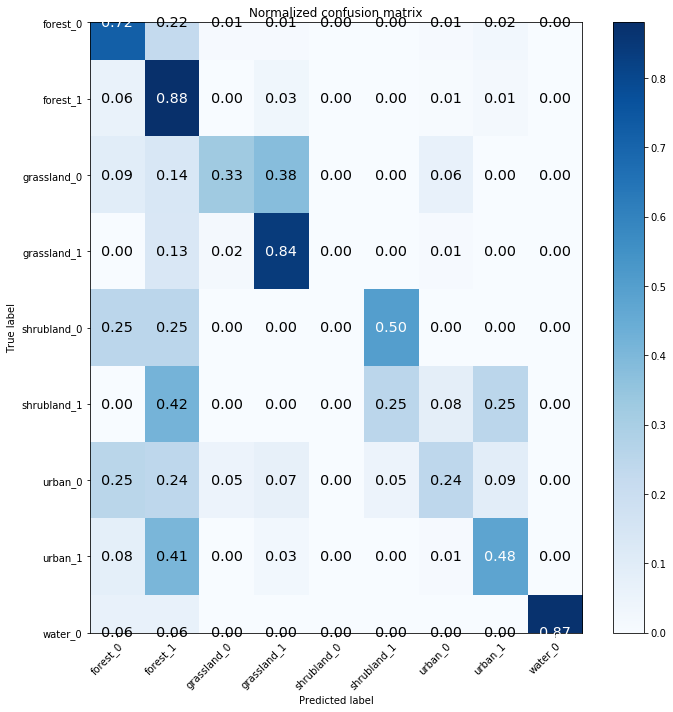

In [105]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=list(le.classes_),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=list(le.classes_), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [106]:
print("Accuracy:")
print(metrics.accuracy_score(y_test, y_predict))

print("\nPrecision:")
print("Macro:", metrics.precision_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.precision_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

print("\nRecall:")
print("Macro:",metrics.recall_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.recall_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

print("\nF1-score:")
print("Macro:",metrics.f1_score(y_test, y_predict, average='macro'))
print("Micro:",metrics.f1_score(y_test, y_predict, average='micro'))
print("Weighted:",metrics.precision_score(y_test, y_predict, average='weighted'))

Accuracy:
0.7586577758657775

Precision:
Macro: 0.5647229766820954
Micro: 0.7586577758657775
Weighted: 0.7572254758717504

Recall:
Macro: 0.5114894170243713
Micro: 0.7586577758657775
Weighted: 0.7572254758717504

F1-score:
Macro: 0.5247755862782705
Micro: 0.7586577758657775
Weighted: 0.7572254758717504


C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [107]:
print(metrics.classification_report(y_test, y_predict, target_names=list(le.classes_)))

              precision    recall  f1-score   support

    forest_0       0.82      0.72      0.77      1223
    forest_1       0.76      0.88      0.82      1970
 grassland_0       0.76      0.33      0.46       310
 grassland_1       0.76      0.84      0.80       777
 shrubland_0       0.00      0.00      0.00         4
 shrubland_1       0.15      0.25      0.19        12
     urban_0       0.30      0.24      0.27        99
     urban_1       0.60      0.48      0.53       223
     water_0       0.93      0.87      0.90        31

    accuracy                           0.76      4649
   macro avg       0.56      0.51      0.52      4649
weighted avg       0.76      0.76      0.75      4649



C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Cross-validation

In [108]:
scores_mlp = cross_val_score(mlp, X_train, y_train, cv=10)
scores_mlp_p = cross_val_score(mlp, X_train, y_train, scoring='precision_weighted', cv=10)
scores_mlp_r = cross_val_score(mlp, X_train, y_train, scoring='recall_weighted', cv=10)
scores_mlp_f = cross_val_score(mlp, X_train, y_train, scoring='f1_weighted', cv=10)
scores_mlp

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 

array([0.74156118, 0.7721519 , 0.73890063, 0.75873016, 0.7309322 ,
       0.76988335, 0.74840764, 0.73566879, 0.7787234 , 0.72204473])

In [109]:
models_df_mlp = pd.DataFrame({  
  'Model': ['ANN-MLP'],
  'Accuracy' : [strScoreConf(scores_mlp.mean(), scores_mlp.std())],
  'Precision': [strScoreConf(scores_mlp_p.mean(), scores_mlp_p.std())],
  'Recall' : [strScoreConf(scores_mlp_r.mean(), scores_mlp_r.std())],
  'F1' : [strScoreConf(scores_mlp_f.mean(), scores_mlp_f.std())]
})
models_df_mlp

,Model,Accuracy,Precision,Recall,F1
0,ANN-MLP,0.7497 (+/- 0.0358),0.7467 (+/- 0.0347),0.7412 (+/- 0.0307),0.7273 (+/- 0.0344)


#### Save models via Pickle

In [111]:
import pickle
filepath = Path("./models")

In [112]:
#random forest
filenameRF = filepath / "randomForest_default_mclass.sav"
pickle.dump(rf, open(filenameRF, 'wb'))

In [113]:
#logistic regression
filenameLR = filepath / "logisticRegression_default_mclass.sav"
pickle.dump(lr, open(filenameLR, 'wb'))

In [114]:
#Gaussian Naive Bayes
filenameGNB = filepath / "gaussNB_default_mclass.sav"
pickle.dump(gnb, open(filenameGNB, 'wb'))

#Bernoulli Naive Bayes
filenameBNB = filepath / "bernNB_default_mclass.sav"
pickle.dump(bnb, open(filenameBNB, 'wb'))

In [115]:
#Stochastic Gradient Descent
filenameSGD = filepath / "stochGradDesc_default_mclass.sav"
pickle.dump(sgd, open(filenameSGD, 'wb'))

In [116]:
#K-Nearest Neighbors - k=5
filenameKNN = filepath / "kNearestNeigh_default_mclass.sav"
pickle.dump(knn, open(filenameKNN, 'wb'))

In [117]:
#Decision Tree Classifier
filenameDTC = filepath / "decisionTree_default_mclass.sav"
pickle.dump(dtc, open(filenameDTC, 'wb'))

In [128]:
#Support Vector Machine - Linear Kernel
filenameSVCLin = filepath / "svm_lin_default_mclass.sav"
pickle.dump(svc_lin, open(filenameSVCLin, 'wb'))

#Support Vector Machine - Radial Basis Function (RBF) Kernel
filenameSVCRbf = filepath / "svm_rbf_default_mclass.sav"
pickle.dump(svc_rbf, open(filenameSVCRbf, 'wb'))

#Support Vector Machine - Polynomial Kernel
filenameSVCPoly = filepath / "svm_poly_default_mclass.sav"
pickle.dump(svc_poly, open(filenameSVCPoly, 'wb'))

In [118]:
#Multi-Layer Perceptron Network (MLP)
filenameMLP = filepath / "mlp_default_mclass.sav"
pickle.dump(mlp, open(filenameMLP, 'wb'))

In [119]:
#save X and y numpy arrays
filepathData = Path("./data")
np.save(filepathData / "X_mclass.npy", X)
np.save(filepathData / "y_mclass.npy", y)

## Cross-validation metrics

In [127]:
models_df = pd.concat([models_df_rf, models_df_lr, models_df_gnb, models_df_bnb,
                       models_df_sgd, models_df_knn, models_df_dtc, models_df_svc, models_df_mlp]) 
models_df.sort_values(by='Precision', ascending=False)

,Model,Accuracy,Precision,Recall,F1
0,RandForest,0.7714 (+/- 0.0272),0.7645 (+/- 0.0374),0.7735 (+/- 0.0318),0.7647 (+/- 0.0311)
0,ANN-MLP,0.7497 (+/- 0.0358),0.7467 (+/- 0.0347),0.7412 (+/- 0.0307),0.7273 (+/- 0.0344)
0,KNN,0.7296 (+/- 0.0290),0.7230 (+/- 0.0298),0.7296 (+/- 0.0290),0.7241 (+/- 0.0291)
0,GaussNB,0.6428 (+/- 0.0200),0.7069 (+/- 0.0151),0.6428 (+/- 0.0200),0.6592 (+/- 0.0168)
0,DecnTree,0.6952 (+/- 0.0323),0.6945 (+/- 0.0268),0.6955 (+/- 0.0321),0.6962 (+/- 0.0265)
0,LogReg,0.7151 (+/- 0.0242),0.6755 (+/- 0.0292),0.7151 (+/- 0.0242),0.6881 (+/- 0.0236)
0,SGD,0.5388 (+/- 0.2254),0.6558 (+/- 0.1500),0.6065 (+/- 0.0954),0.5015 (+/- 0.2264)
0,SVM,0.5642 (+/- 0.0139),0.6514 (+/- 0.0340),0.5642 (+/- 0.0139),0.5073 (+/- 0.0187)
0,BernNB,0.6115 (+/- 0.0282),0.5703 (+/- 0.0437),0.6115 (+/- 0.0282),0.5649 (+/- 0.0254)
